# Capstone: Web Traffic Time Series Forecasting

![web](images/map_webtraffic.png)

reference: [Kaggle Challenge 2017](https://www.kaggle.com/competitions/web-traffic-time-series-forecasting/data)

- Web traffic can be defined as the number of visits to a website, including requests sent and received by web users. We aim to predict future web traffic for approximately a total of 145k Wikipedia articles to make better traffic control decisions. The increase in traffic for the websites could cause a lot of inconvenience for the users by a crashed site or very slow loading time. Therefore, a traffic management technique or plan should be put in place to reduce the risk of such problems.

# Import packages and define functions

In [266]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm # to show Japanese & Chinese character
import re
import seaborn as sns
import datetime 
from collections import Counter

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

sns.set_style('ticks', rc={'xtick.direction':'in', 'ytick.direction':'in', \
                           'xtick.top':True, 'ytick.right':True})

# Data Load

In [2]:
datadir = '../datasets/raw'
datadir_pr = '../datasets/processed'  # directory where the cleaned datasets are stored

## Datasets consist of train and key:
- **train.csv**
    - 145k rows each of wich represent a different Wikipedia page
    - 804 columns: article + daily traffic on that particular Wikipedia page (803 days: 2015-07-01 to 2017-09-10)
    - The first column contains the name of the page which includes 
        - the language of the page (e.g., English en, Spanish es, Chinese zh)
        - type of access (e.g., desktop, all access)
        - agent (e.g., spider, actual traffic)
- **key.csv**
    - the mapping between the page names and the shortened Id column used for prediction
    - 2 columns: page name (consistent to the page name in train.csv) and id

In [23]:
''' Read the training dataset '''
train = pd.read_csv(os.path.join(datadir_pr, 'train_imputed.csv.zip'))
#key   = pd.read_csv(os.path.join(datadir, 'key_2.csv.zip'))

In [54]:
train.head()

,Page,2015-07-01 00:00:00,2015-07-02 00:00:00,2015-07-03 00:00:00,2015-07-04 00:00:00,2015-07-05 00:00:00,2015-07-06 00:00:00,2015-07-07 00:00:00,2015-07-08 00:00:00,2015-07-09 00:00:00,...,2017-09-04 00:00:00,2017-09-05 00:00:00,2017-09-06 00:00:00,2017-09-07 00:00:00,2017-09-08 00:00:00,2017-09-09 00:00:00,2017-09-10 00:00:00,Language,Agent,Access
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,18.0,16.0,27.0,29.0,23.0,54.0,38.0,Chinese,spider,all-access
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,19.0,54.0,25.0,26.0,23.0,13.0,81.0,Chinese,spider,all-access
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,2.0,4.0,7.0,3.0,4.0,7.0,6.0,Chinese,spider,all-access
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,9.0,6.0,16.0,19.0,30.0,38.0,4.0,Chinese,spider,all-access
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,20.0,23.0,28.0,14.0,8.0,7.0,Chinese,spider,all-access


In [78]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 807 entries, Page to 2017-09-10 00:00:00
dtypes: float64(803), object(4)
memory usage: 893.1+ MB


In [62]:
''' re-order the column: 
    currently Language, Agent, Access columns are located at the end of column
    -> pull into right after Page columns
    '''

cols = train.columns.tolist()
cols = [cols[0]] + cols[-3:] + cols[1:-3]
train = train.loc[:,cols]

In [67]:
train.sample(5)

,Page,Language,Agent,Access,2015-07-01 00:00:00,2015-07-02 00:00:00,2015-07-03 00:00:00,2015-07-04 00:00:00,2015-07-05 00:00:00,2015-07-06 00:00:00,...,2017-09-01 00:00:00,2017-09-02 00:00:00,2017-09-03 00:00:00,2017-09-04 00:00:00,2017-09-05 00:00:00,2017-09-06 00:00:00,2017-09-07 00:00:00,2017-09-08 00:00:00,2017-09-09 00:00:00,2017-09-10 00:00:00
57112,小林涼子_ja.wikipedia.org_mobile-web_all-agents,Japanese,all-agents,mobile-web,469.0,517.0,669.0,580.0,539.0,369.0,...,439.0,512.0,482.0,388.0,358.0,510.0,410.0,276.0,368.0,372.0
92097,Octubre_es.wikipedia.org_all-access_all-agents,Spanish,all-agents,all-access,286.0,248.0,173.0,178.0,192.0,226.0,...,825.0,563.0,668.0,853.0,946.0,808.0,822.0,603.0,418.0,490.0
89597,ジェイミー夏樹_ja.wikipedia.org_desktop_all-agents,Japanese,all-agents,desktop,0.0,0.0,0.0,0.0,0.0,0.0,...,23.0,30.0,27.0,26.0,36.0,23.0,22.0,38.0,31.0,29.0
17143,"Лавроненко,_Константин_Николаевич_ru.wikipedia...",Russian,all-agents,mobile-web,22.0,36.0,41.0,41.0,42.0,50.0,...,148.0,116.0,146.0,102.0,86.0,117.0,103.0,136.0,150.0,139.0
119103,SERVAMP_-サーヴァンプ-_ja.wikipedia.org_all-access_a...,Japanese,all-agents,all-access,116.0,117.0,114.0,170.0,182.0,162.0,...,285.0,494.0,621.0,411.0,288.0,315.0,302.0,246.0,372.0,422.0


# Feature Engineering

In [91]:
''' wide format to long format by using pandas.melt '''

#train_flattened = pd.melt(train[list(train.columns[-20:])+['Page','Language','Agent','Access']], id_vars=['Page','Language','Agent','Access'], var_name='date', value_name='Visits')
train_flattened = pd.melt(train, id_vars=['Page','Language','Agent','Access'], var_name='date', value_name='Visits')

In [92]:
''' to datetime format '''
train_flattened.date = pd.to_datetime(train_flattened.date)

In [93]:
train_flattened['weekday'] = train_flattened['date'].apply(lambda x: x.weekday())
train_flattened['weekend'] = ((train_flattened.date.dt.dayofweek) // 5 == 1).astype(float)

train_flattened['year']=train_flattened.date.dt.year 
train_flattened['month']=train_flattened.date.dt.month 
train_flattened['day']=train_flattened.date.dt.day

In [94]:
train_flattened

,Page,Language,Agent,Access,date,Visits,weekday,weekend,year,month,day
0,2NE1_zh.wikipedia.org_all-access_spider,Chinese,spider,all-access,2015-07-01,18.0,2,0.0,2015,7,1
1,2PM_zh.wikipedia.org_all-access_spider,Chinese,spider,all-access,2015-07-01,11.0,2,0.0,2015,7,1
2,3C_zh.wikipedia.org_all-access_spider,Chinese,spider,all-access,2015-07-01,1.0,2,0.0,2015,7,1
3,4minute_zh.wikipedia.org_all-access_spider,Chinese,spider,all-access,2015-07-01,35.0,2,0.0,2015,7,1
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,Chinese,spider,all-access,2015-07-01,0.0,2,0.0,2015,7,1
...,...,...,...,...,...,...,...,...,...,...,...
116485584,Underworld_(serie_de_películas)_es.wikipedia.o...,Spanish,spider,all-access,2017-09-10,2.0,6,1.0,2017,9,10
116485585,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,Spanish,spider,all-access,2017-09-10,4.0,6,1.0,2017,9,10
116485586,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,Spanish,spider,all-access,2017-09-10,6.0,6,1.0,2017,9,10
116485587,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,Spanish,spider,all-access,2017-09-10,3.0,6,1.0,2017,9,10


## Check weekly averaged total view

In [115]:
week_group = train_flattened[['Page','weekday','Visits']].groupby(['weekday']).mean()

In [116]:
week_group

,Visits
weekday,
0,1360.811280
1,1305.256725
2,1287.498449
3,1255.011104
4,1212.157618
5,1225.888199
6,1326.380835


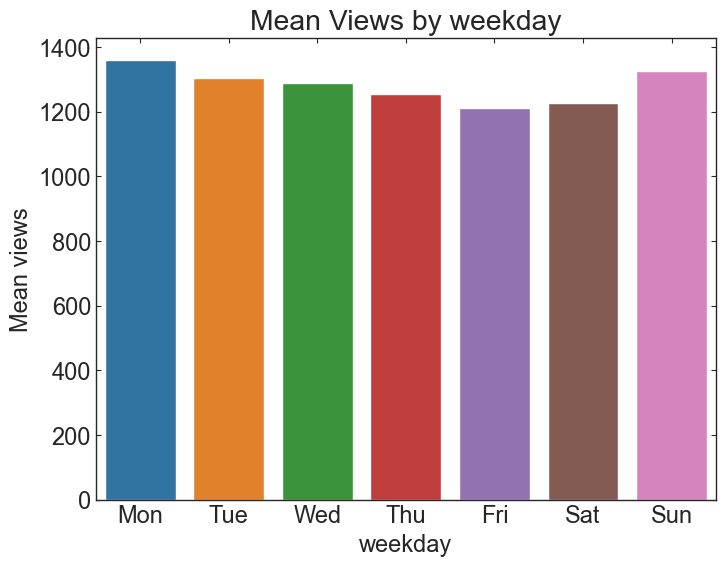

In [118]:
# ytick format function 
# 'B' stands for billion (1e9)
#ticklabel_func = lambda value, tick_number: "{:.0f}B".format(value/1e9)

# xtick format function 
week_name = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
ticklabel_func2 = lambda value, tick_number: week_name[value]

ax = sns.barplot(data=week_group.T)

ax.xaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func2))
#ax.yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
ax.tick_params(axis='x')
ax.set(title='Mean Views by weekday', ylabel='Mean views');

## Check monthly averaged total view

In [240]:
month_group = train_flattened[['month','Visits']].groupby(['month']).mean()

In [241]:
month_group

,Visits
month,
1,1478.257373
2,1442.406120
3,1284.650886
4,1261.892368
5,1225.984335
6,1171.003058
7,1186.623835
8,1252.392473
9,1235.659223


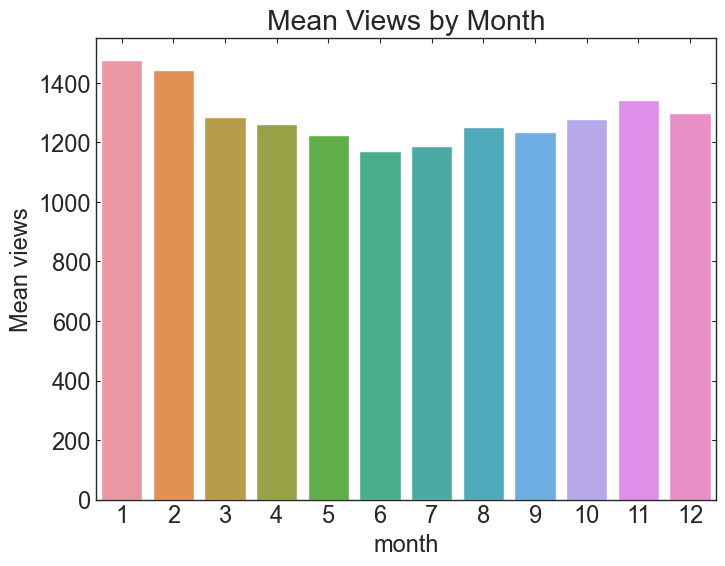

In [242]:
# ytick format function 
# 'B' stands for billion (1e9)
#ticklabel_func = lambda value, tick_number: "{:.0f}B".format(value/1e9)

ax = sns.barplot(data=month_group.T)

#ax.yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
ax.tick_params(axis='x')
ax.set(title='Mean Views by Month', ylabel='Mean views');

## Check yearly averaged total view

In [123]:
year_group = train_flattened[['year','Visits']].groupby(['year']).mean()

In [124]:
year_group

,Visits
year,
2015,1119.775017
2016,1408.650106
2017,1215.908594


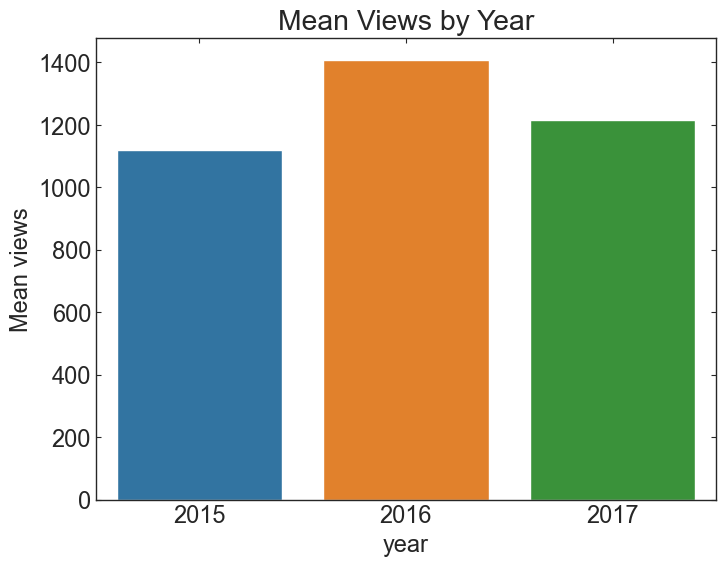

In [125]:
# ytick format function 
# 'B' stands for billion (1e9)
#ticklabel_func = lambda value, tick_number: "{:.0f}B".format(value/1e9)

ax = sns.barplot(data=year_group.T)

#ax.yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
ax.tick_params(axis='x')
ax.set(title='Mean Views by Year', ylabel='Mean views');

## Check weekend vs. weekdays for total view

In [127]:
weekend_group = train_flattened[['weekend','Visits']].groupby(['weekend']).mean()

In [128]:
weekend_group

,Visits
weekend,
0.0,1283.976400
1.0,1276.134517


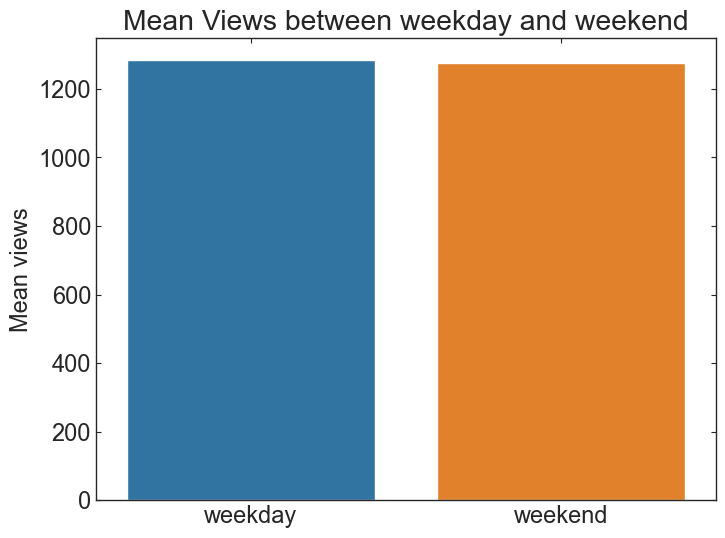

In [132]:
# xtick format function 
weekend_name = {0:'weekday', 1:'weekend'}
ticklabel_func = lambda value, tick_number: weekend_name[value]

ax = sns.barplot(data=weekend_group.T)

ax.xaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
ax.tick_params(axis='x')
ax.set(title='Mean Views between weekday and weekend', ylabel='Mean views', xlabel='');

## Prepare the daily averaged total view for ML

In [144]:
mean_timeSeries = train_flattened[['date','weekday','weekend','year','month','day','Visits']].groupby(['date']).mean()

In [146]:
mean_timeSeries

,weekday,weekend,year,month,day,Visits
date,,,,,,
2015-07-01,2.0,0.0,2015.0,7.0,1.0,1024.882127
2015-07-02,3.0,0.0,2015.0,7.0,2.0,1031.251727
2015-07-03,4.0,0.0,2015.0,7.0,3.0,973.138768
2015-07-04,5.0,1.0,2015.0,7.0,4.0,1003.810839
2015-07-05,6.0,1.0,2015.0,7.0,5.0,1044.361908
...,...,...,...,...,...,...
2017-09-06,2.0,0.0,2017.0,9.0,6.0,1192.459890
2017-09-07,3.0,0.0,2017.0,9.0,7.0,1250.224337
2017-09-08,4.0,0.0,2017.0,9.0,8.0,947.043023


In [147]:
mean_timeSeries.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 803 entries, 2015-07-01 to 2017-09-10
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   weekday  803 non-null    float64
 1   weekend  803 non-null    float64
 2   year     803 non-null    float64
 3   month    803 non-null    float64
 4   day      803 non-null    float64
 5   Visits   803 non-null    float64
dtypes: float64(6)
memory usage: 43.9 KB


In [159]:
''' rolling data '''
mean_timeSeries_roll7 = mean_timeSeries['Visits'].rolling(7).mean()
mean_timeSeries_roll7.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 803 entries, 2015-07-01 to 2017-09-10
Series name: Visits
Non-Null Count  Dtype  
--------------  -----  
797 non-null    float64
dtypes: float64(1)
memory usage: 12.5 KB


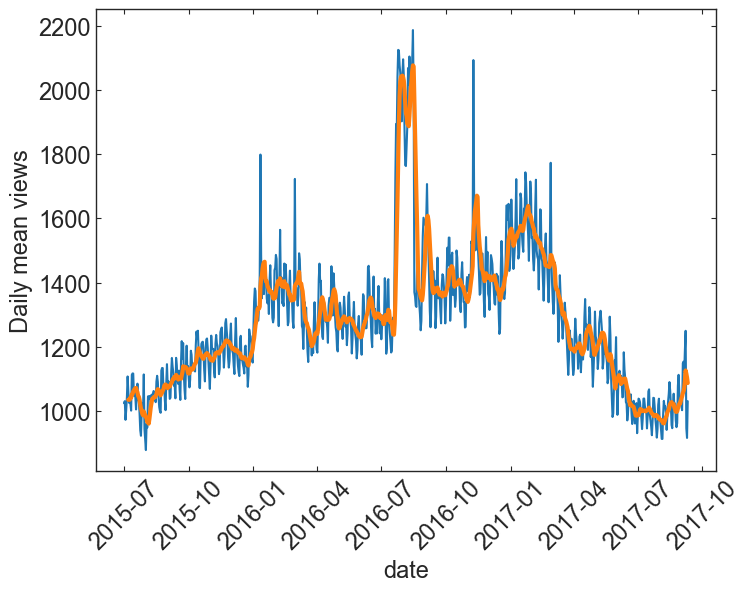

In [163]:
fig, ax = plt.subplots()

ax = sns.lineplot(data=mean_timeSeries, y='Visits', x=mean_timeSeries.index)
sns.lineplot(data=mean_timeSeries_roll7, lw=3, color='C1', ax=ax)
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Daily mean views');

# Check the stationarity

In [164]:
decmp = seasonal_decompose(mean_timeSeries.Visits, model='multiplicative')

decmp_seasonal = decmp.seasonal
decmp_trend = decmp.trend
decmp_resid = decmp.resid

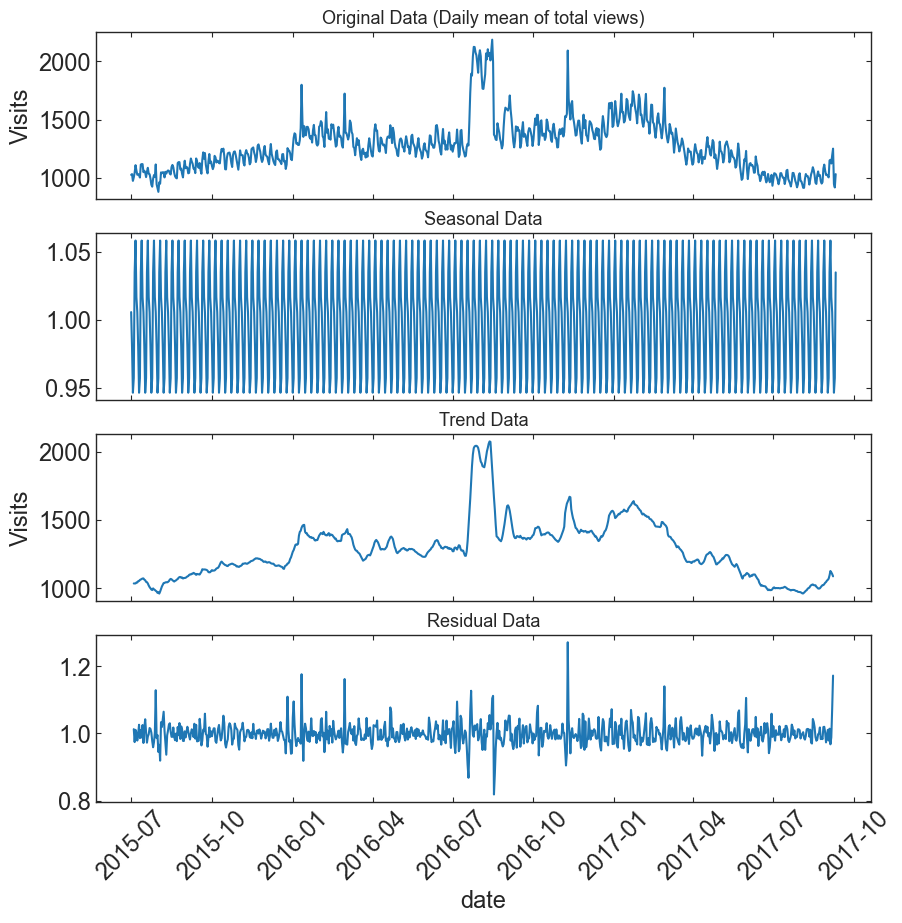

In [177]:
# Plot the original data, the trend, the seasonality, and the residuals 

fig, axes = plt.subplots(4,1, figsize=(10,10), sharex=True)
axf = axes.flat

title_size=13
# original data
sns.lineplot(x=mean_timeSeries.index, y=mean_timeSeries.Visits, ax=axf[0])
axf[0].set_title('Original Data (Daily mean of total views)', size=title_size)
#ticklabel_func = lambda value, tick_number: "{:.1f} K".format(value/1e3) 
#axf[0].yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))

# Seasonal data
sns.lineplot(x=mean_timeSeries.index, y=decmp.seasonal, ax=axf[1])
axf[1].set_title('Seasonal Data', size=title_size)
axf[1].set_ylabel('')
#ticklabel_func = lambda value, tick_number: "{:.5f}".format(value) 
#axf[1].yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))

# Trend data
sns.lineplot(x=mean_timeSeries.index, y=decmp.trend, ax=axf[2])
axf[2].set_title('Trend Data', size=title_size)
axf[2].set_ylabel('Visits')
#ticklabel_func = lambda value, tick_number: "{:.1f} K".format(value/1e3) 
#axf[2].yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
#axf[2].tick_params(axis='x', rotation=45)

# Residual data
sns.lineplot(x=mean_timeSeries.index, y=decmp.resid, ax=axf[3])
axf[3].set_title('Residual Data', size=title_size)
axf[3].set_ylabel('')
#ticklabel_func = lambda value, tick_number: "{:.5f}".format(value) 
#axf[3].yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
axf[3].tick_params(axis='x', rotation=45)

# adjust spaces
fig.subplots_adjust(hspace=0.2)

In [250]:
def report_stationarity(TS_data):
    ''' conduct Augmented Dickey Fuller test to 
        evaluate the stationarity of the Time series 
    '''
    
    result   = adfuller(TS_data)
    adf      = result[0]
    p_val    = result[1]
    crit_val = result[4]
    print('test statistics: {}'.format(adf))
    print('p-value: {}'.format(p_val))
    print('critical values: {}'.format(crit_val))
    print('-'*100)
    
    if (p_val < 0.05) and (adf < crit_val['5%']):
        print('The series is likely stationary!!')
    else:
        print('The series is NOT likely stationary!!')

In [251]:
# print out the ADF summary
report_stationarity(mean_timeSeries.Visits)

test statistics: -2.6910718741582897
p-value: 0.07559600807637526
critical values: {'1%': -3.438750669890019, '5%': -2.8652477937238703, '10%': -2.56874438754281}
----------------------------------------------------------------------------------------------------
The series is NOT likely stationary!!


## Making the Time Series data Stationary

### Log Transformation

In [252]:
ts_log = mean_timeSeries[['Visits']].copy()
ts_log['Log_Visits'] = np.log(ts_log.Visits)

# print out the ADF summary
report_stationarity(ts_log.Log_Visits)

test statistics: -2.292321199650115
p-value: 0.17445649893813603
critical values: {'1%': -3.438750669890019, '5%': -2.8652477937238703, '10%': -2.56874438754281}
----------------------------------------------------------------------------------------------------
The series is NOT likely stationary!!


### Differencing

In [254]:
''' differencing '''
ts_diff = mean_timeSeries[['Visits']].copy()
ts_diff['Diff_Visits'] = mean_timeSeries.Visits.diff()
#ts_diff.dropna(inplace=True)

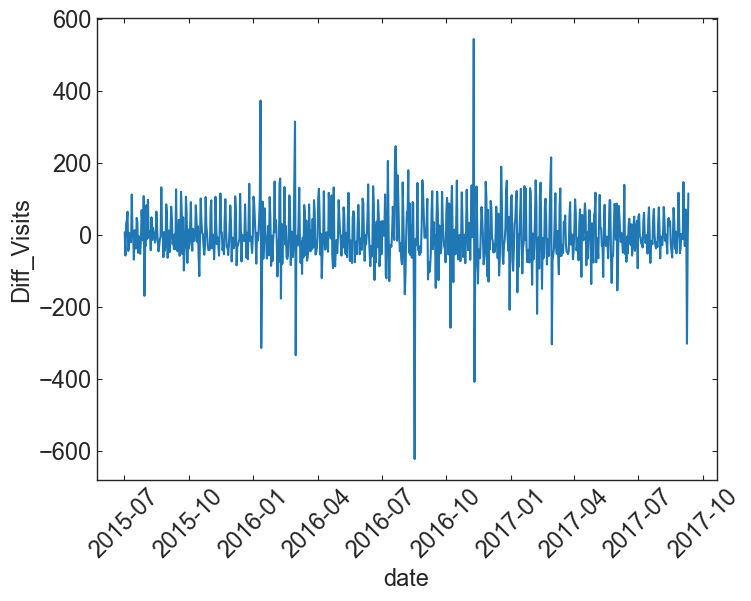

In [255]:
fig, ax = plt.subplots()

sns.lineplot(y=ts_diff.Diff_Visits, x=ts_diff.index, ax=ax)
ax.tick_params(axis='x', rotation=45);

In [256]:
# drop NaN values due to the differencing
ts_diff.dropna(inplace=True)

# print out the ADF summary
report_stationarity(ts_diff.Diff_Visits)

test statistics: -5.4831859294854945
p-value: 2.2602014375575467e-06
critical values: {'1%': -3.4387614757350087, '5%': -2.865252556432172, '10%': -2.5687469247205788}
----------------------------------------------------------------------------------------------------
The series is likely stationary!!


In [298]:
''' Differencing with logarithmic transformation '''
ts_log_diff = mean_timeSeries[['Visits']].copy()
ts_log_diff['Log_Diff_Visits'] = ts_log.Log_Visits.diff()
#ts_diff.dropna(inplace=True)

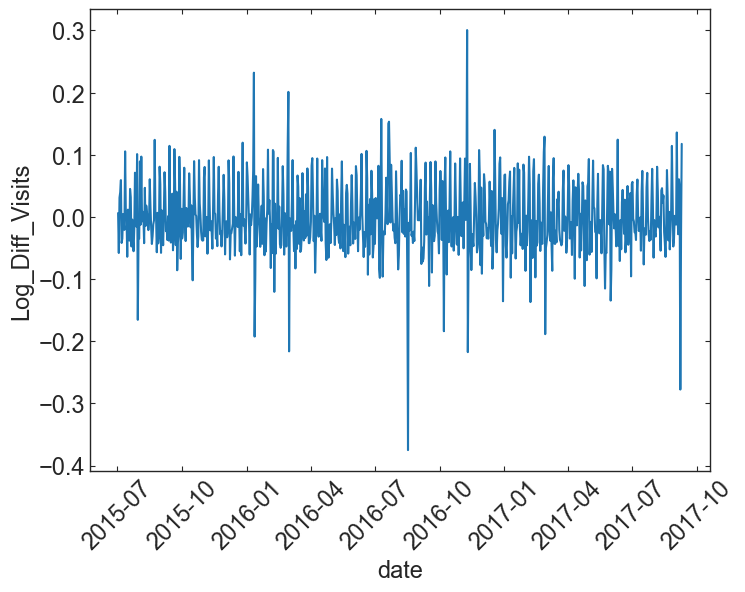

In [299]:
fig, ax = plt.subplots()

sns.lineplot(y=ts_log_diff.Log_Diff_Visits, x=ts_log_diff.index, ax=ax)
ax.tick_params(axis='x', rotation=45);

In [300]:
# drop NaN values due to the differencing
ts_log_diff.dropna(inplace=True)

# print out the ADF summary
report_stationarity(ts_log_diff.Log_Diff_Visits)

test statistics: -5.565137059519054
p-value: 1.5107278806152643e-06
critical values: {'1%': -3.4387614757350087, '5%': -2.865252556432172, '10%': -2.5687469247205788}
----------------------------------------------------------------------------------------------------
The series is likely stationary!!


# Modeling
- SARIMA
- Prophet
- LSTM

## SARIMA Modeling

### Auto-correlation function (ACF) and Partial auto-correlation function (PACF)

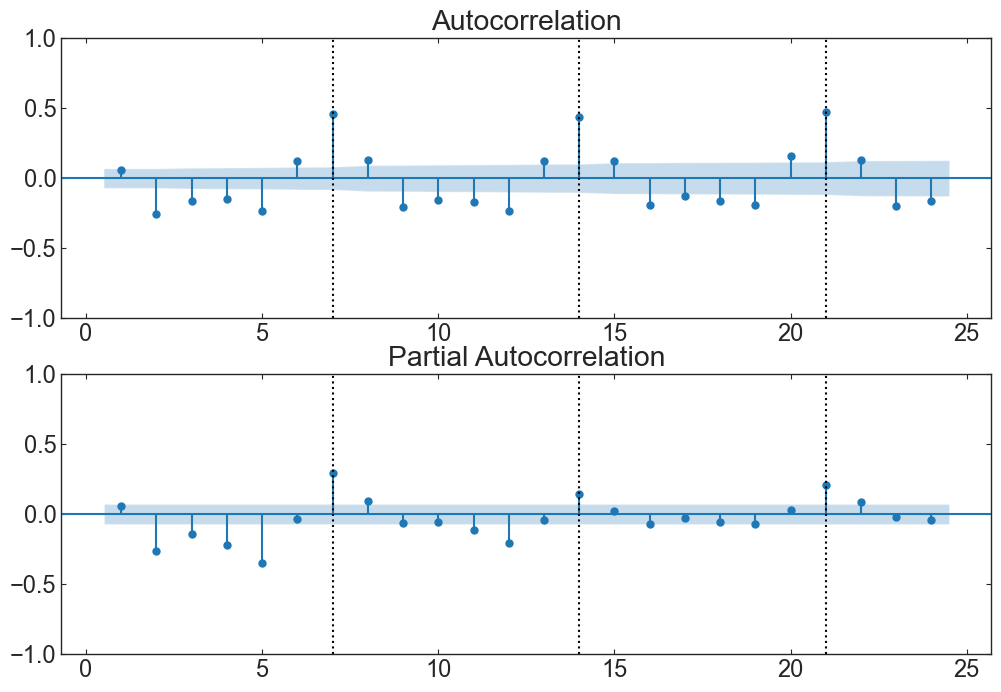

In [301]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot ACF
plot_acf(ts_log_diff.Log_Diff_Visits, lags=24, zero=False, ax=ax1)
ax1.axvline(x=7, linestyle=':', color='black')
ax1.axvline(x=14, linestyle=':', color='black')
ax1.axvline(x=21, linestyle=':', color='black')

# Plot PACF
plot_pacf(ts_log_diff.Log_Diff_Visits, lags=24, zero=False, ax=ax2, method='ywm')
ax2.axvline(x=7, linestyle=':', color='black')
ax2.axvline(x=14, linestyle=':', color='black')
ax2.axvline(x=21, linestyle=':', color='black');

> In ACF and PACF, we could observe high correlation for 7 days lag.
> There is weekly seasonality in data.

In [302]:
# Create auto_arima model
# Find best sarima model by evaluating AIC values
model_sarima = pm.auto_arima(ts_log_diff['Log_Diff_Visits'], seasonal=True, m=7, d=0, D=1, \
                      max_p=2, max_q=2, \
                      trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[7] intercept   : AIC=inf, Time=2.14 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=-2230.478, Time=0.15 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=-2442.806, Time=0.50 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=-2232.474, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=-2240.775, Time=0.19 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=-2559.767, Time=1.25 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=1.98 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=-2544.383, Time=0.55 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=-2567.304, Time=1.33 sec
 ARIMA(2,0,0)(1,1,0)[7] intercept   : AIC=-2445.802, Time=0.47 sec
 ARIMA(2,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=2.30 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(2,0,1)(2,1,0)[7] intercept   : AIC=-2568.158, Ti

In [303]:
# Print model summary
print(model_sarima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  802
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood                1361.466
Date:                           Tue, 10 Jan 2023   AIC                          -2710.931
Time:                                   01:50:48   BIC                          -2682.861
Sample:                                        0   HQIC                         -2700.145
                                           - 802                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.664e-05   4.48e-05     -0.371      0.710      -0.000    7.12e-05
ar.L1          0.4152      0.075      5.513

In [317]:
# Forecast
n_periods = 60
sarima_forecast, sarima_confint = model_sarima.predict(n_periods=n_periods, return_conf_int=True)

In [318]:
''' combine the last data point to forecast results '''

date_forecast = pd.date_range(start=ts_log_diff.index[-1], periods=n_periods+1, freq='D') # to include the last date of the original dataset: n_periods+1

last_point = ts_log_diff.Log_Diff_Visits[-1]
sarima_forecast = np.append(last_point, sarima_forecast)

sarima_confint = np.append([[last_point,last_point]], sarima_confint, axis=0)

In [365]:
''' Convert that range into a dataframe that includes predictions'''

df_sarima_forecast = pd.DataFrame(np.column_stack([sarima_forecast, sarima_confint[:,0], sarima_confint[:,1]]), \
                                  columns=['Prediction', 'Low_Conf', 'High_Conf'], index=date_forecast)
df_sarima_forecast.index.set_names('date', inplace=True)

df_sarima_forecast

,Prediction,Low_Conf,High_Conf
date,,,
2017-09-10,0.117515,0.117515,0.117515
2017-09-11,0.030725,-0.054120,0.115570
2017-09-12,-0.029244,-0.116755,0.058267
2017-09-13,-0.004315,-0.092278,0.083647
2017-09-14,-0.021069,-0.109109,0.066971
...,...,...,...
2017-11-05,0.080814,-0.008918,0.170546
2017-11-06,0.015957,-0.073992,0.105907
2017-11-07,-0.035555,-0.125518,0.054409


In [366]:
df_sarima_forecast.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2017-09-10 to 2017-11-09
Freq: D
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Prediction  61 non-null     float64
 1   Low_Conf    61 non-null     float64
 2   High_Conf   61 non-null     float64
dtypes: float64(3)
memory usage: 1.9 KB


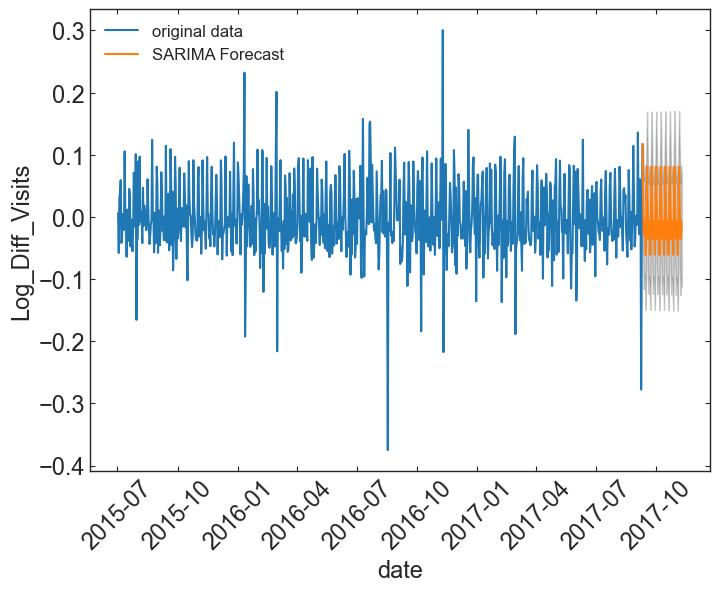

In [367]:
''' Plottiing the prediction along with the original dataset '''
fig, ax = plt.subplots()

sns.lineplot(y=ts_log_diff.Log_Diff_Visits, x=ts_log_diff.index, label='original data', ax=ax)
sns.lineplot(y=df_sarima_forecast.Prediction, x=df_sarima_forecast.index, label='SARIMA Forecast', ax=ax)
ax.fill_between(df_sarima_forecast.index, df_sarima_forecast.Low_Conf, df_sarima_forecast.High_Conf, \
               alpha=0.2, color='k')
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', fontsize=12, frameon=False);

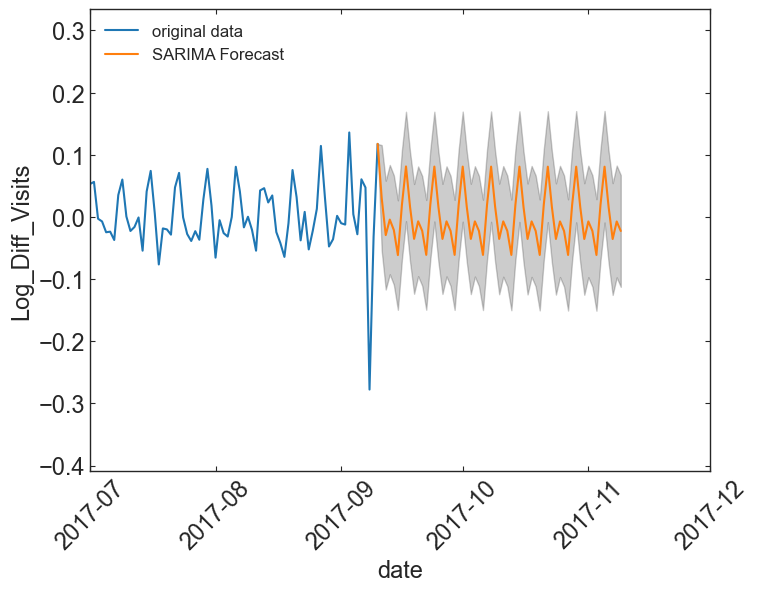

In [368]:
''' Zoomed-in plotting'''
fig, ax = plt.subplots()

sns.lineplot(y=ts_log_diff.Log_Diff_Visits, x=ts_log_diff.index, label='original data', ax=ax)
sns.lineplot(y=df_sarima_forecast.Prediction, x=df_sarima_forecast.index, label='SARIMA Forecast', ax=ax)
ax.fill_between(df_sarima_forecast.index, df_sarima_forecast.Low_Conf, df_sarima_forecast.High_Conf, \
               alpha=0.2, color='k')

ax.set_xlim([pd.to_datetime('2017-07'),pd.to_datetime('2017-12')])
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', fontsize=12, frameon=False);

In [385]:
''' rebuild the actual prediction from logarithmic and differenced prediction '''

pred_tmp = df_sarima_forecast.Prediction
pred_tmp[0] = 0   # the first element of the prediction should be zero, and will be calibrated by the last Visits of original data

df_sarima_forecast['Prediction_Actual'] = np.exp(pred_tmp.cumsum())*mean_timeSeries.Visits[-1]

In [386]:
df_sarima_forecast

,Prediction,Low_Conf,High_Conf,Prediction_Actual
date,,,,
2017-09-10,0.000000,0.117515,0.117515,1031.082730
2017-09-11,0.030725,-0.054120,0.115570,1063.254453
2017-09-12,-0.029244,-0.116755,0.058267,1032.610823
2017-09-13,-0.004315,-0.092278,0.083647,1028.164512
2017-09-14,-0.021069,-0.109109,0.066971,1006.728903
...,...,...,...,...
2017-11-05,0.080814,-0.008918,0.170546,979.667781
2017-11-06,0.015957,-0.073992,0.105907,995.426036
2017-11-07,-0.035555,-0.125518,0.054409,960.655848


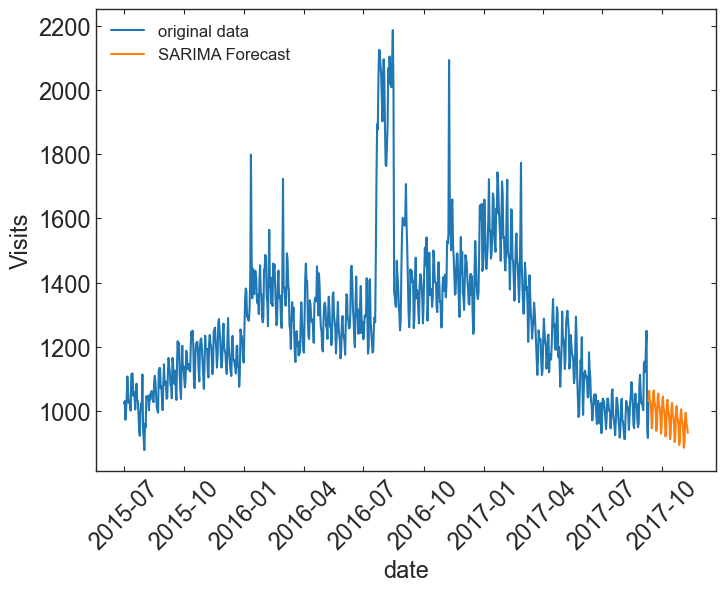

In [387]:
''' Plottiing the prediction along with the original dataset '''
fig, ax = plt.subplots()

sns.lineplot(y=mean_timeSeries.Visits, x=mean_timeSeries.index, label='original data', ax=ax)
sns.lineplot(y=df_sarima_forecast.Prediction_Actual, x=df_sarima_forecast.index, label='SARIMA Forecast', ax=ax)

ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', fontsize=12, frameon=False);

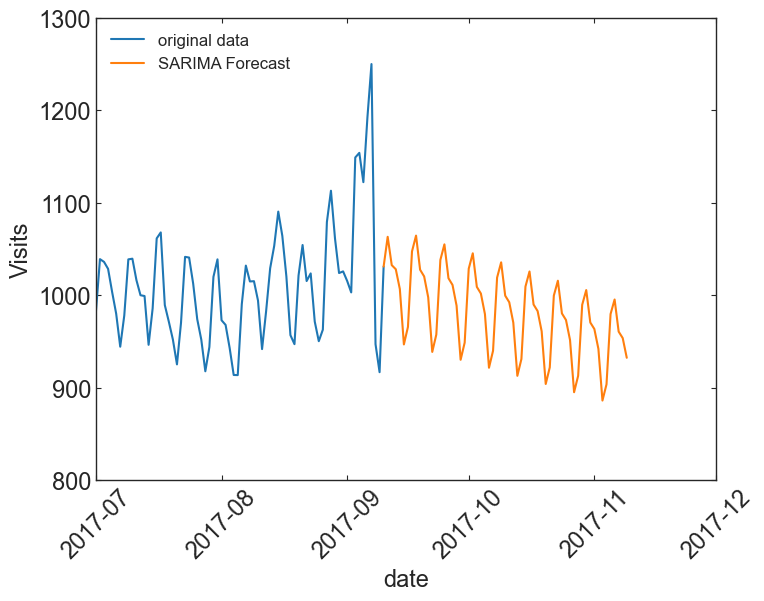

In [388]:
''' Zoomed-in plotting '''
fig, ax = plt.subplots()

sns.lineplot(y=mean_timeSeries.Visits, x=mean_timeSeries.index, label='original data', ax=ax)
sns.lineplot(y=df_sarima_forecast.Prediction_Actual, x=df_sarima_forecast.index, label='SARIMA Forecast', ax=ax)

ax.set_xlim([pd.to_datetime('2017-07'),pd.to_datetime('2017-12')])
ax.set_ylim(800,1300)
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', fontsize=12, frameon=False);

## Prophet Modeling

## LSTM Modeling

# Conclusion